In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.eda_methods import show_barplot, load_data
from pandas.plotting import register_matplotlib_converters

pd.set_option('display.max_colwidth', 125)
register_matplotlib_converters()

In [2]:
old_commits, new_commits, cc_df, bic = load_data('accumulo')

In [3]:
# selects cochange of at least two components with confidence higher that 0.5
relevant_cc =\
    cc_df[
        (cc_df.support_count > 1) & (cc_df.confidence >= 0.5)
    ].reset_index(drop=True).copy()

# relevant_cc = cc_df.reset_index(drop=True).copy()

# frees memory
del cc_df

**Note** that the hashes for cochange are the same as in new_commits but the hashes for bug introducing commits (bic) is the same as in old_commits. Thus, we must convert bic hashes into new_commits hashes.

In [4]:
# relevant_cc.iloc[0].commit_hash[0] in new_commits.values

# drops duplicated hashes 
bic = bic[~bic.duplicated()].reset_index(drop=True)
print('Number of bug introducing commits: {0}'.format(len(bic)))

Number of bug introducing commits: 775


In [5]:
# creates a dataframe to support conversion of old hashes into new ones
conv_df = pd.DataFrame()
conv_df['old_hash'] = old_commits.sort_index()
conv_df['new_hash'] =\
    new_commits.sort_index()\
    .reset_index(drop=True)[
        old_commits\
        .sort_index()\
        .reset_index(drop=True)\
        .index
    ].values

In [6]:
# converts bic's old hashes into new ones
bic =\
    conv_df.set_index('old_hash')\
    .squeeze()[bic.values]\
    .reset_index(drop=True)

# frees memory
del conv_df

### > How frequent are commits that introduce bugs?

In [7]:
# len(np.unique(bic.values)) / len(np.unique(old_commits.values))
len(np.intersect1d(bic.values, new_commits.values)) / len(np.unique(new_commits.values))

0.07531584062196307

### > How common is cochange in the project?

In [8]:
print(
    '{0:.3f} of all commits show cochange dependency between components (support > 1, confidence >= 0.5).'
    .format(
        len(np.unique(np.hstack(relevant_cc.commit_hash.values))) / len(np.unique(old_commits.values))
    )
)

0.067 of all commits show cochange dependency between components (support > 1, confidence >= 0.5).


### > Of all commits with cochange dependency, how many introduce bugs?

In [9]:
len(np.intersect1d(np.hstack(relevant_cc.commit_hash.values), bic.values)) / len(np.unique(np.hstack(relevant_cc.commit_hash.values)))

0.11661807580174927

### > Of all commits that introduce bugs, how many have cochange dependency? (questionable)

In [10]:
len(np.intersect1d(np.hstack(relevant_cc.commit_hash.values), bic.values)) / len(bic.values)

0.1032258064516129

## Distribuition of bug introducing commits over cochange dependency support (level)

### > Broad Overview

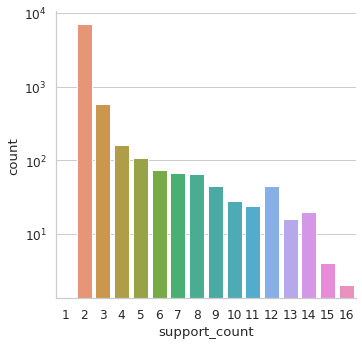

In [23]:
show_barplot(relevant_cc, 'support_count', y_logscale='log')

### > How many of the observations are unique?

In [25]:
# hashes the list of commits to check for duplicates
relevant_cc['id_hash'] = relevant_cc.commit_hash.apply(lambda x: hash(tuple(x)))

In [26]:
print(
    'Unique hashes of list of commit_hash: {0}\n'
    .format(
        len(relevant_cc) - relevant_cc.set_index('id_hash').index.duplicated().sum()
    )
    + 'Should the order of components influence the co-change dependency (a,b != b,a ?)? It does at this time.'
)

Unique hashes of list of commit_hash: 677
Should the order of components influence the co-change dependency (a,b != b,a ?)? It does at this time.


In [29]:
unique_cc =\
    relevant_cc[
        ~relevant_cc.set_index('id_hash')
        .index.duplicated()
    ].reset_index(drop=True).copy()

unique_cc

# frees memory
del relevant_cc

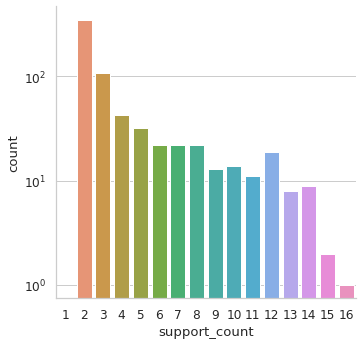

In [28]:
show_barplot(unique_cc, 'support_count', y_logscale=True)

### > How are bugs distributed over support_count categories?

In [31]:
unique_cc['bic_count'] =\
    unique_cc.commit_hash.apply(
        lambda x: len(
            [
                commit_h for commit_h in x
                if commit_h in bic.values
            ]
        )
    )

unique_cc['bic_percent'] =\
    unique_cc[unique_cc.bic_count > 0][['commit_hash', 'bic_count']]\
    .apply(lambda x: x[1] / len(x[0]), axis=1)

unique_cc.bic_percent = unique_cc.bic_percent.fillna(0.0)

In [32]:
for name, group in unique_cc.groupby('support_count'):
    print('> Support count ', name)
    print('Cochange instances: \t\t', len(group))
    print('Cochange instances with bugs: \t', group[group['bic_count'] > 0]['bic_count'].count())
    print('Individual bic count: \t\t', group['bic_count'].sum(), '\n')

> Support count  1
Cochange instances: 		 0
Cochange instances with bugs: 	 0
Individual bic count: 		 0 

> Support count  2
Cochange instances: 		 351
Cochange instances with bugs: 	 72
Individual bic count: 		 81 

> Support count  3
Cochange instances: 		 108
Cochange instances with bugs: 	 35
Individual bic count: 		 42 

> Support count  4
Cochange instances: 		 43
Cochange instances with bugs: 	 13
Individual bic count: 		 17 

> Support count  5
Cochange instances: 		 32
Cochange instances with bugs: 	 19
Individual bic count: 		 23 

> Support count  6
Cochange instances: 		 22
Cochange instances with bugs: 	 19
Individual bic count: 		 23 

> Support count  7
Cochange instances: 		 22
Cochange instances with bugs: 	 20
Individual bic count: 		 37 

> Support count  8
Cochange instances: 		 22
Cochange instances with bugs: 	 22
Individual bic count: 		 47 

> Support count  9
Cochange instances: 		 13
Cochange instances with bugs: 	 13
Individual bic count: 		 29 

> Support c

In [33]:
# sns.catplot();
# unique_cc.groupby('support_count').agg(lambda x: x[x.bic_count > 0].bic_count.count() / len(x)).bic_count
compare_cc_bugs = pd.DataFrame()
compare_cc_bugs['cc_bugs'] = unique_cc.groupby('support_count').agg(lambda x: x[x.bic_count > 0].count()).bic_count
compare_cc_bugs['cc_count'] = unique_cc.groupby('support_count').count().commit_hash
compare_cc_bugs['cc_groups_with_bugs_percent'] = compare_cc_bugs.cc_bugs / compare_cc_bugs.cc_count
compare_cc_bugs['unique_commits_with_bugs_percent'] = unique_cc.groupby('support_count').mean().bic_percent
compare_cc_bugs['unique_commits_with_bugs_std'] = unique_cc.groupby('support_count').bic_percent.std().fillna(0.0)

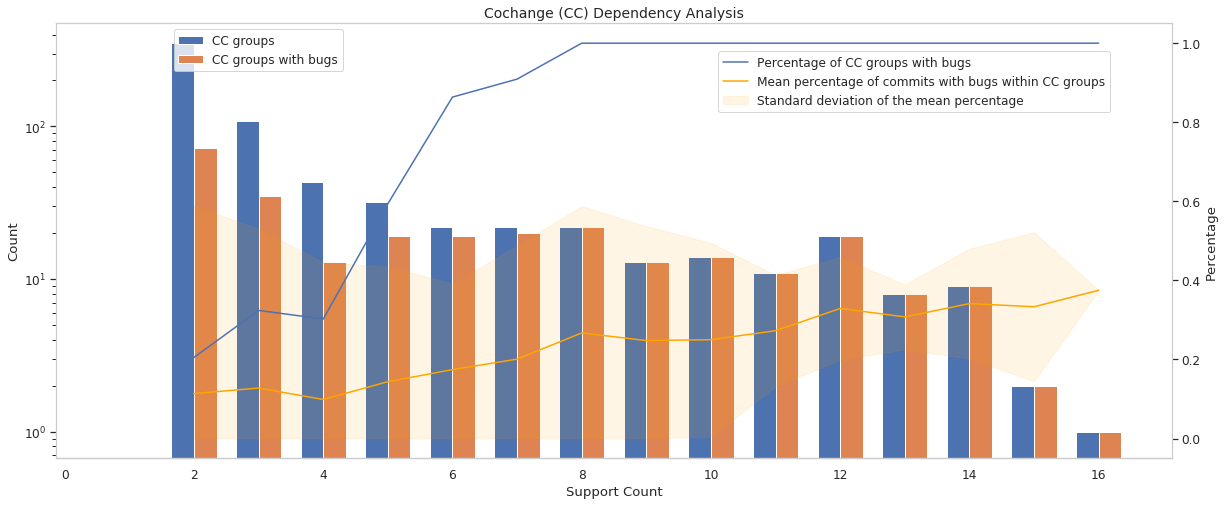

In [34]:
sns.set_style("whitegrid", {'axes.grid' : False})

# creates the subplot
fig, ax1 = plt.subplots(figsize=(20, 8))
width = 0.35

# sets up the primary plot
ax1.set_title('Cochange (CC) Dependency Analysis', fontsize=14)
ax1.set_ylabel('Count')
ax1.set_xlabel('Support Count')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1 .spines['left'].set_visible(False)


# plots the first bar
bar1 = ax1.bar(
    compare_cc_bugs.reset_index(drop=True).index + 1 - width/2,
    compare_cc_bugs['cc_count'],
    width,
    log=True,
    label='CC groups'
)

# plots the second bar
bar2 = ax1.bar(
    compare_cc_bugs.reset_index(drop=True).index + 1 + width/2,
    compare_cc_bugs['cc_bugs'],
    width,
    log=True,
    label='CC groups with bugs'
)
plt.legend(loc='upper left', bbox_to_anchor=(0.1, 1.0))

# sets up the secondary subplot
ax2 = ax1.twinx()
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
# ax2.spines['left'].set_visible(False)
ax2.set_ylabel('Percentage')

# plots the first line
line1 = ax2.plot(
    compare_cc_bugs.index,
    compare_cc_bugs['cc_groups_with_bugs_percent'],
    label='Percentage of CC groups with bugs',
    color='b'
)

# plots the second line
line2 = ax2.plot(
    compare_cc_bugs.index,
    compare_cc_bugs['unique_commits_with_bugs_percent'],
    label='Mean percentage of commits with bugs within CC groups',
    color='orange'
)

# plots the standard deviation area
fill = ax2.fill_between(
    compare_cc_bugs.index,
    (compare_cc_bugs['unique_commits_with_bugs_percent'] + 2 * compare_cc_bugs['unique_commits_with_bugs_std']).values,
    y2=(compare_cc_bugs['unique_commits_with_bugs_percent'] - 2 * compare_cc_bugs['unique_commits_with_bugs_std']).apply(lambda x: 0 if x < 0 else x).values,
    color='orange', alpha=.1, label='Standard deviation of the mean percentage'
)
plt.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95))

plt.show()

Compare the same data with commits without cochange. Relate the percentage of bugs in commits without cochange and commits with cochange

In [41]:
# new_commits[new_commits.apply(lambda x: x in cochange_commits)]

# gets an array of unique commit hashes with cochange dependency
cochange_commits = np.unique(np.hstack(unique_cc['commit_hash'].values))

# filters the series of commits to have only cochange dependency
if type(cochange_commits) == np.ndarray:
    cochange_commits = new_commits[new_commits.apply(lambda x: x in cochange_commits)]

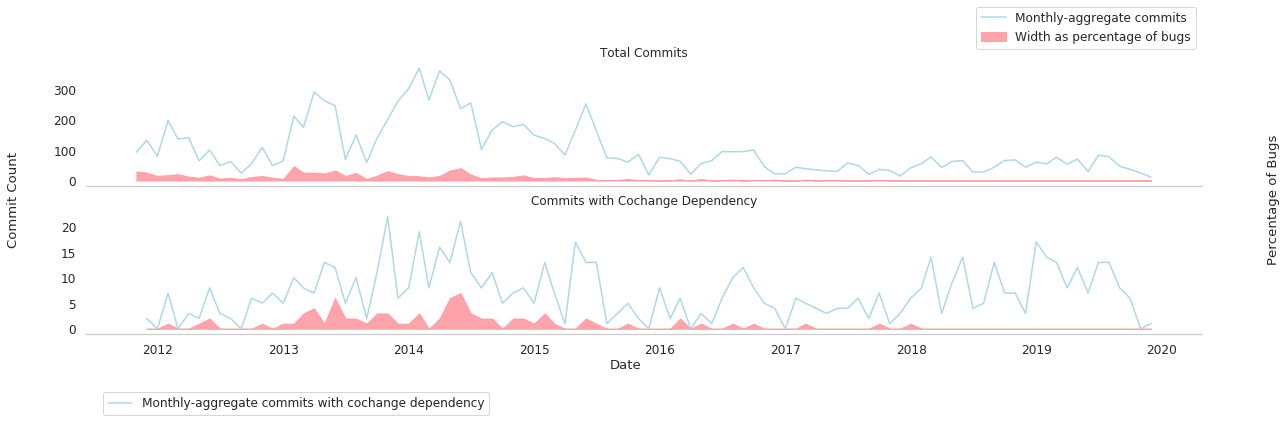

In [49]:
# initializes dataframes for plotting
commits_monthly_count = new_commits.resample('M').count()
bugs_commits_monthly_count= new_commits[new_commits.apply(lambda x: x in bic.values)].resample('M').count()
cochange_commits_monthly_count = cochange_commits.resample('M').count()
cochange_bug_commits_monthly_count = cochange_commits[cochange_commits.apply(lambda x: x in bic.values)].resample('M').count()

# creates the subplots
fig, ax = plt.subplots(2, 1, figsize=(20,5), sharex=True)
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.075, 0.5, 'Commit Count', ha='center', va='center', rotation='vertical')
fig.text(0.95, 0.5, 'Percentage of Bugs', ha='center', va='center', rotation='vertical')

# sets up the first plot
ax[0].set_title('Total Commits', fontsize=12)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)

line1 = ax[0].plot(
    commits_monthly_count.index.date,
    commits_monthly_count.values,
    label='Monthly-aggregate commits',
    color='lightblue'
)


# line2 = ax[0].plot(
#     bugs_commits_monthly_count.index.date,
#     bugs_commits_monthly_count,
#     label='Monthly-aggregate commits with bugs',
#     color='#FF9AA2',
#     linewidth=2.0
# )
ax[0].legend(loc='upper left', bbox_to_anchor=(0.01, 1.5))

# ax2 = ax[0].twinx()
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
# ax2.spines['left'].set_visible(False)

ratio = (bugs_commits_monthly_count / commits_monthly_count).fillna(0.0)
fill = ax[0].fill_between(
    commits_monthly_count.index.date,
    (commits_monthly_count * ratio).fillna(0.0).values,
    # y2=(bugs_commits_monthly_count - 100*ratio).fillna(0.0).values,
    color='#FF9AA2', alpha=.9, label='Width as percentage of bugs'
)
# fill = ax2.bar(ratio.index.date, ratio.values, 5.0, color='red', alpha=.5, label='Monthly Percentage of Bugs')
ax[0].legend(loc='upper right', bbox_to_anchor=(1.0, 1.5))

# sets up the second plot
ax[1].set_title('Commits with Cochange Dependency', fontsize=12)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)

line3 = ax[1].plot(
    cochange_commits_monthly_count.index.date,
    cochange_commits_monthly_count.values,
    label='Monthly-aggregate commits with cochange dependency',
    color='lightblue',
)

# line4 = ax[1].plot(
#     cochange_bug_commits_monthly_count.index.date,
#     cochange_bug_commits_monthly_count.values,
#     label='Monthly-aggregate commits with cochange dependency and bugs',
#     color='#B5EAD7',
#     linewidth=2.0
# )
ax[1].legend(loc='lower left', bbox_to_anchor=(0.01, -0.7))

# ax3 = ax[1].twinx()
# # ax3.set_ylabel('Percentage of Bugs')
# ax3.spines['top'].set_visible(False)
# ax3.spines['right'].set_visible(False)
# ax3.spines['left'].set_visible(False)

# ratio = (cochange_bug_commits_monthly_count / cochange_commits_monthly_count).fillna(0.0)
# fill = ax3.bar(ratio.index.date, ratio.values, 7.0, color='red', alpha=.5, label='Monthly Percentage of Bugs')
ratio = (cochange_bug_commits_monthly_count / cochange_commits_monthly_count).fillna(0.0)
fill = ax[1].fill_between(
    cochange_commits_monthly_count.index.date,
    (cochange_commits_monthly_count * ratio).fillna(0.0).values,
    # y2=(bugs_commits_monthly_count - 100*ratio).fillna(0.0).values,
    color='#FF9AA2', alpha=.9, label='Width as percentage of bugs'
)

plt.show()
# new_commits.resample('M').count().plot(kind='bar', figsize=(20,5))